<a href="https://colab.research.google.com/github/hufsaim/T10306201/blob/master/notebook_2021/Lab07_Classification_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel]"
!python -c "import matplotlib" || pip install -q matplotlib

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     |████████████████████████████████| 681 kB 5.1 MB/s 


In [ ]:
path0 = '/content/drive/MyDrive/data/brats18/brats18_train' # replace your data path
dpiv = 80

In [ ]:
from monai.transforms import (
    AddChanneld,
    Compose,
    LoadImaged,
    CenterSpatialCropd,
    NormalizeIntensityd,
    RandSpatialCropd,
    ToTensord,
)
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.utils import first
from monai.networks.nets import EfficientNet, EfficientNetBN

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import os
import glob

In [ ]:

if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

print(device)

cuda:0


In [ ]:
path_list = glob.glob(os.path.join(path0,'Brats18*'))
len(path_list)

100

In [ ]:
train_ind = np.arange(0,80)
data_dicts = [
    {
        "image": os.path.join(path_list[idx],
                                    "t1ce.nii.gz"),
        "label": os.path.join(path_list[idx],
                                    "seg.nii.gz"),
    }
    for idx in train_ind
]
train_files =  data_dicts

In [ ]:
valid_ind = np.arange(80,96)
data_dicts = [
    {
        "image": os.path.join(path_list[idx],
                                    "t1ce.nii.gz"),
        "label": os.path.join(path_list[idx],
                                    "seg.nii.gz"),
    }
    for idx in valid_ind
]
valid_files =  data_dicts

In [ ]:
train_transforms = Compose(
    [
      LoadImaged(keys=("image","label")),
      AddChanneld(keys=("image","label")),
      CenterSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 96]),
      NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
      RandSpatialCropd(keys=["image", "label"], roi_size=[192, 192, 1],random_size=False),
      ToTensord(keys=["image", "label"]),
    ]
)

valid_transforms = Compose(
    [
      LoadImaged(keys=("image","label")),
      AddChanneld(keys=("image","label")),
      CenterSpatialCropd(keys=["image", "label"], roi_size=[192, 192, 96]),
      NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
      ToTensord(keys=["image", "label"]),
    ]
)

In [ ]:
train_ds = Dataset(data = train_files, transform = train_transforms)
train_loader = DataLoader(train_ds,batch_size = 16)

In [ ]:
valid_ds = Dataset(data = valid_files, transform = valid_transforms)
valid_loader = DataLoader(valid_ds,batch_size = 1)

torch.Size([16, 1, 192, 192, 1])
torch.Size([16, 1, 192, 192, 1])


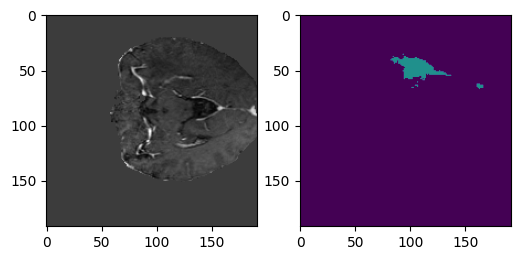

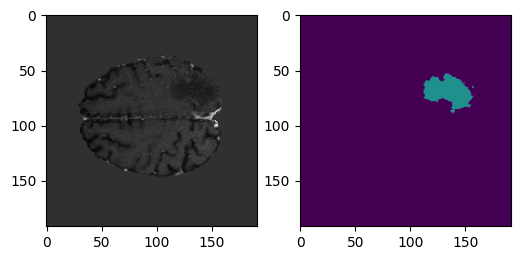

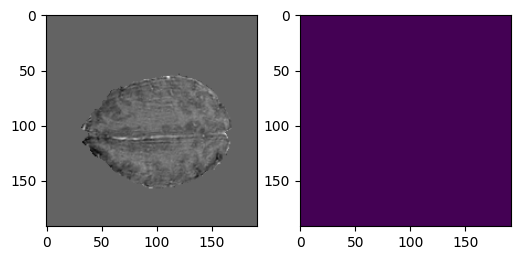

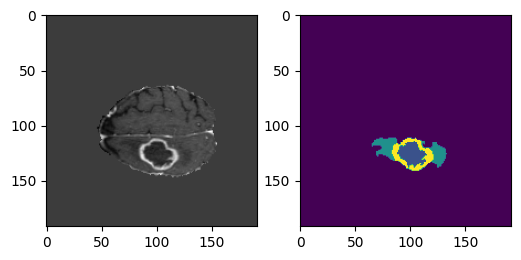

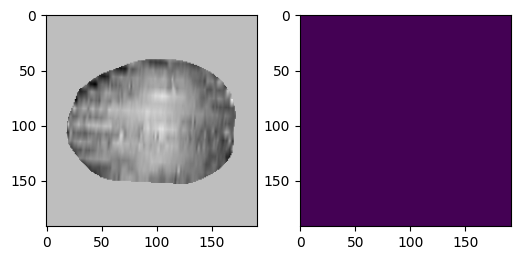

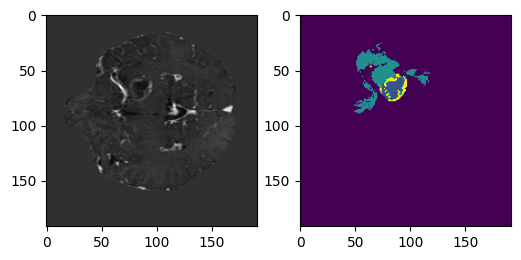

torch.Size([16, 1, 192, 192, 1])
torch.Size([16, 1, 192, 192, 1])


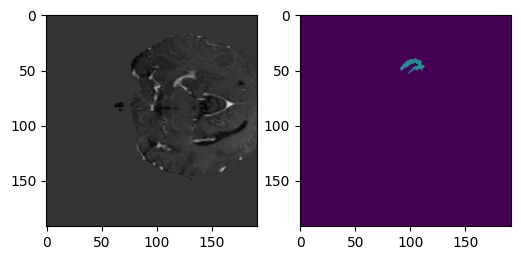

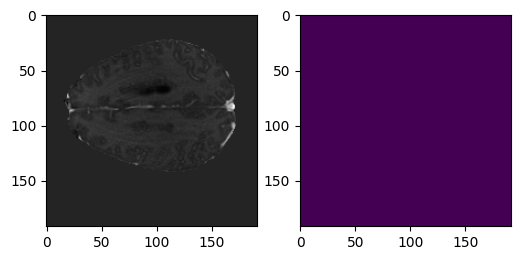

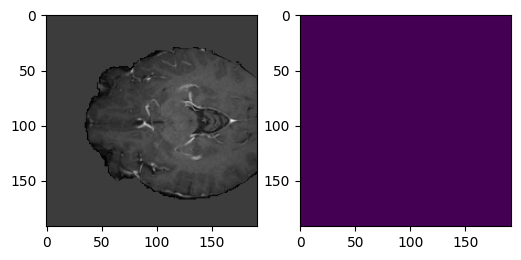

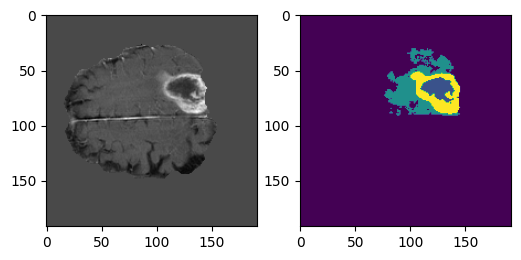

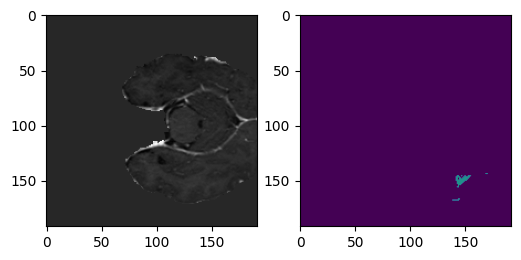

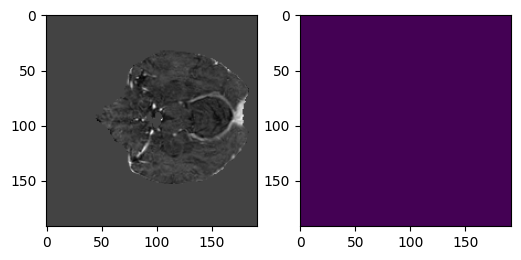

torch.Size([16, 1, 192, 192, 1])
torch.Size([16, 1, 192, 192, 1])


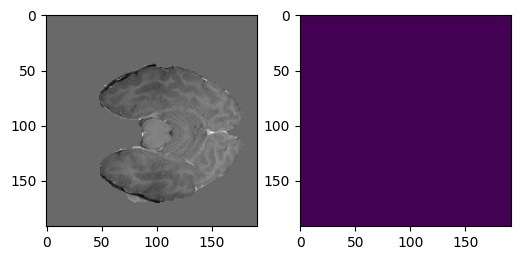

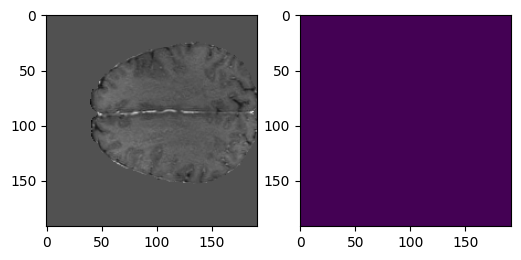

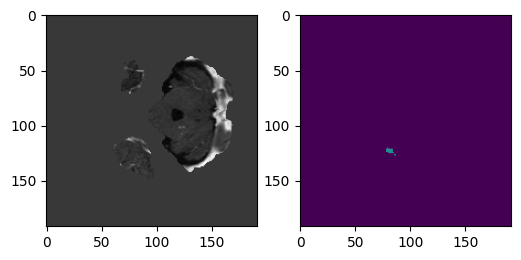

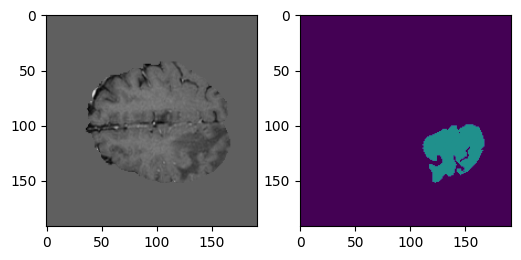

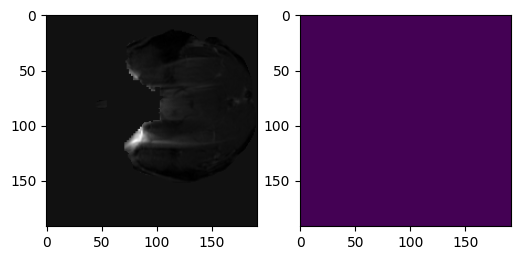

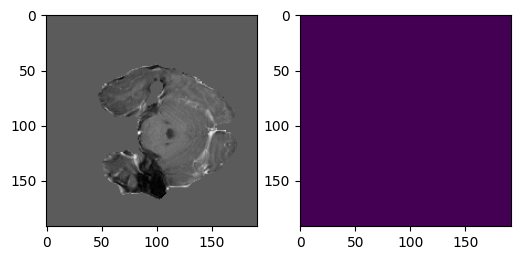

torch.Size([16, 1, 192, 192, 1])
torch.Size([16, 1, 192, 192, 1])


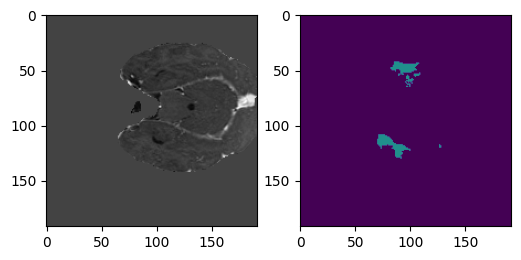

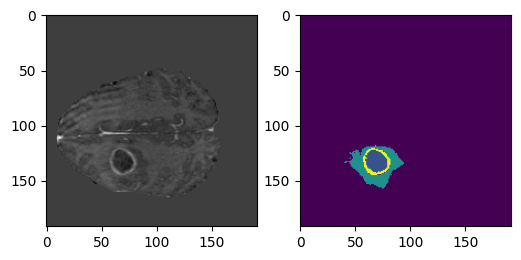

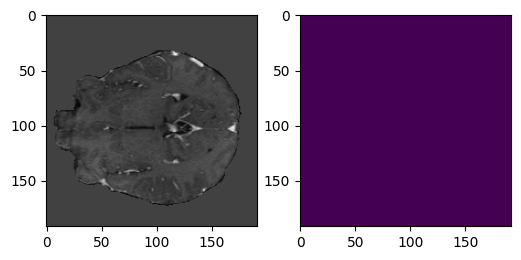

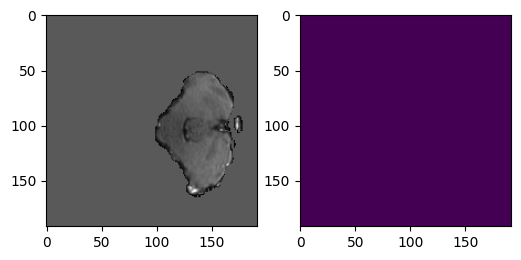

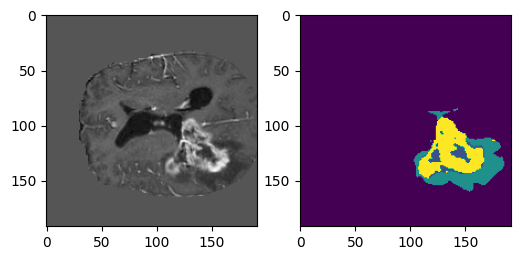

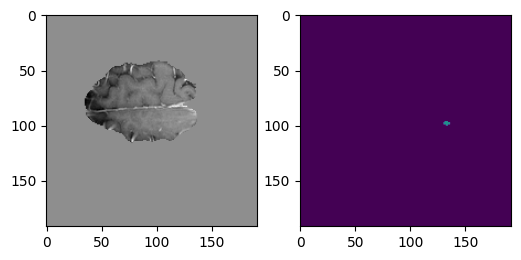

torch.Size([16, 1, 192, 192, 1])
torch.Size([16, 1, 192, 192, 1])


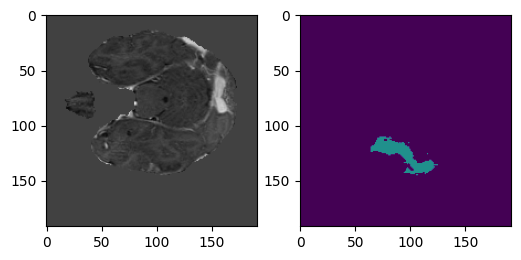

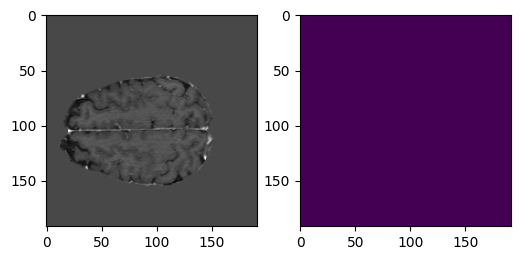

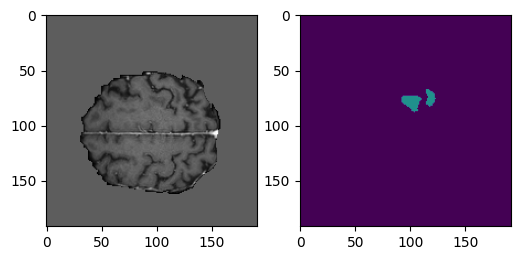

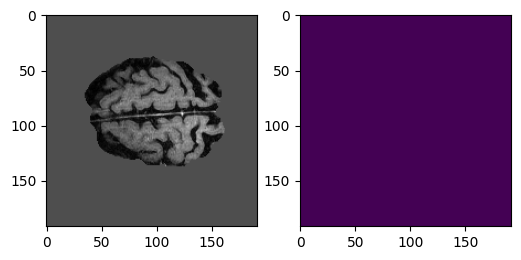

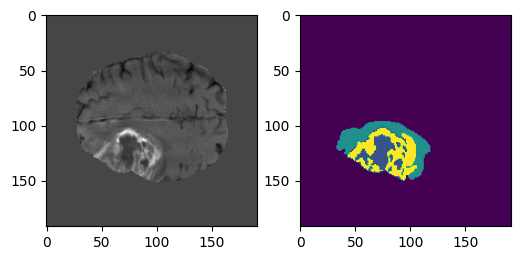

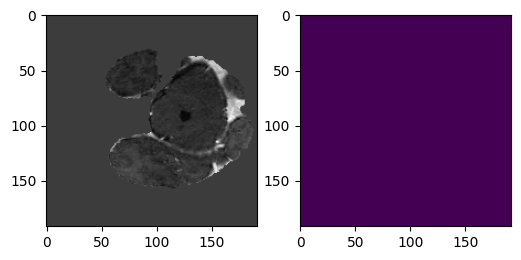

In [ ]:
cnt = 0
for data in train_loader:
  print(data["image"].shape)
  print(data["label"].shape)

  for n in range(0,len(data["image"])):
    plt.figure(dpi=100)
    plt.subplot(121)
    plt.imshow(data["image"][n,0,:,:,0],cmap='gray')
    plt.subplot(122)
    plt.imshow(data["label"][n,0,:,:,0],vmin=0,vmax=4)
    plt.show()
    if n>4:
      break
 

In [ ]:
label = data["label"]==4
label = torch.sum(torch.sum(label,axis = 3),axis = 2).squeeze()
print(label)
label = label>0
print(label)
label = label.type(torch.LongTensor)
print(label)

tensor([   0,    0,    0,    0, 1196,    0,    0,    0,   75,    0, 1426,    0,
           0,    1,  297,    0])
tensor([False, False, False, False,  True, False, False, False,  True, False,
         True, False, False,  True,  True, False])
tensor([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0])


In [ ]:
lenet = torch.nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2), # 192x192
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),  # 96x96
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),# 48x 48
    nn.Flatten(),
    nn.Linear(in_features=16*48*48, out_features=120),
    nn.ReLU(),
    nn.Linear(120, 84),
    nn.ReLU(),
    nn.Linear(84, 2)
)
lenet = lenet.to(device)
lenet

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=36864, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=2, bias=True)
)

In [ ]:
l1 = lenet[0]
l2 = lenet[1]
l3 = lenet[2]
print(l1)
print(l2)
print(l3)

Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
ReLU()
AvgPool2d(kernel_size=2, stride=2, padding=0)


In [ ]:
X0 = torch.randn((1,1,192,192)).to(device)
print(X0.shape)
X1 = l1(X0)
print(X1.shape)
X2 = l2(X1)
print(X2.shape)
X3 = l3(X2)
print(X3.shape)

torch.Size([1, 1, 192, 192])
torch.Size([1, 6, 192, 192])
torch.Size([1, 6, 192, 192])
torch.Size([1, 6, 96, 96])


In [ ]:
X = torch.randn(size=(4,1,192,192), dtype = torch.float32).to(device)
for layer in lenet:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([4, 6, 192, 192])
ReLU output shape: 	 torch.Size([4, 6, 192, 192])
AvgPool2d output shape: 	 torch.Size([4, 6, 96, 96])
Conv2d output shape: 	 torch.Size([4, 16, 96, 96])
ReLU output shape: 	 torch.Size([4, 16, 96, 96])
AvgPool2d output shape: 	 torch.Size([4, 16, 48, 48])
Flatten output shape: 	 torch.Size([4, 36864])
Linear output shape: 	 torch.Size([4, 120])
ReLU output shape: 	 torch.Size([4, 120])
Linear output shape: 	 torch.Size([4, 84])
ReLU output shape: 	 torch.Size([4, 84])
Linear output shape: 	 torch.Size([4, 2])


In [ ]:
X = torch.randn(size=(4,1,192,192), dtype = torch.float32).to(device)
y_hat = lenet(X)
print(y_hat)

tensor([[-0.0932,  0.1210],
        [-0.0932,  0.1280],
        [-0.0891,  0.1216],
        [-0.0972,  0.1221]], device='cuda:0', grad_fn=<AddmmBackward>)


# Model

In [ ]:
net = EfficientNetBN("efficientnet-b7",spatial_dims=2, in_channels=1,
                    num_classes=2).to(device)
loss = torch.nn.CrossEntropyLoss()
alg = torch.optim.Adam(net.parameters(), 1e-5)
learning_rate = 0.0042
num_epochs = 128

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth


  0%|          | 0.00/254M [00:00<?, ?B/s]

# Train

predicted: tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
label: tensor([0, 0, 0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')


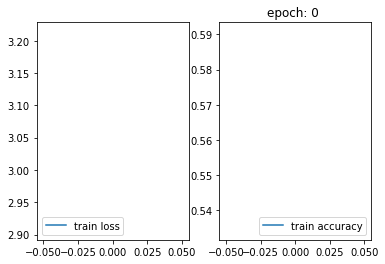

train loss:  3.0601116180419923
train accuracy:  0.5625
predicted: tensor([1, 1, 0, 1, 1, 1, 1, 1, 0, 0], device='cuda:0')
label: tensor([1, 0, 1, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
predicted: tensor([1, 0, 1, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
label: tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
predicted: tensor([0, 1, 0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
label: tensor([0, 0, 0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
predicted: tensor([1, 0, 0, 1, 0, 1, 1, 0, 0, 1], device='cuda:0')
label: tensor([1, 0, 0, 0, 1, 1, 1, 0, 1, 1], device='cuda:0')
predicted: tensor([0, 0, 0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
label: tensor([0, 0, 1, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
predicted: tensor([0, 1, 0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
label: tensor([1, 0, 0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
predicted: tensor([0, 1, 1, 1, 1, 0, 1, 1, 0, 1], device='cuda:0')
label: tensor([0, 0, 0, 1, 0, 0, 0, 1, 0, 1], device='cuda:0')
predicted: tensor([1, 1, 1, 0, 0, 

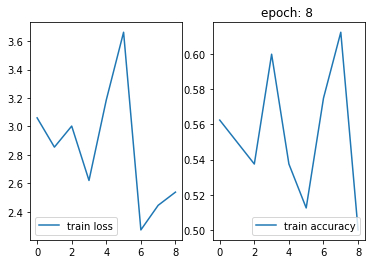

train loss:  2.5378246307373047
train accuracy:  0.5
predicted: tensor([1, 0, 1, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
label: tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
predicted: tensor([1, 1, 1, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')
label: tensor([1, 0, 0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
predicted: tensor([0, 1, 1, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
label: tensor([1, 0, 0, 1, 0, 0, 1, 1, 0, 0], device='cuda:0')
predicted: tensor([1, 0, 1, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
label: tensor([0, 0, 0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
predicted: tensor([1, 1, 0, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
label: tensor([0, 0, 0, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
predicted: tensor([1, 1, 0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
label: tensor([0, 0, 0, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
predicted: tensor([1, 0, 1, 0, 1, 1, 0, 1, 0, 1], device='cuda:0')
label: tensor([0, 0, 1, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
predicted: tensor([0, 0, 1, 0, 1, 1, 

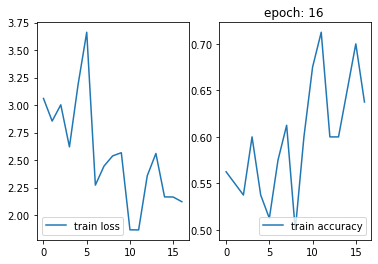

train loss:  2.121196746826172
train accuracy:  0.637499988079071
predicted: tensor([0, 0, 0, 1, 1, 0, 1, 1, 1, 0], device='cuda:0')
label: tensor([1, 0, 0, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
predicted: tensor([1, 1, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
label: tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
predicted: tensor([1, 1, 1, 0, 1, 1, 1, 0, 0, 1], device='cuda:0')
label: tensor([0, 0, 0, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
predicted: tensor([1, 0, 0, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
label: tensor([0, 0, 0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
predicted: tensor([1, 1, 0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
label: tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
predicted: tensor([0, 0, 1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
label: tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
predicted: tensor([1, 1, 0, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
label: tensor([1, 0, 0, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
predicted: tensor([0, 0,

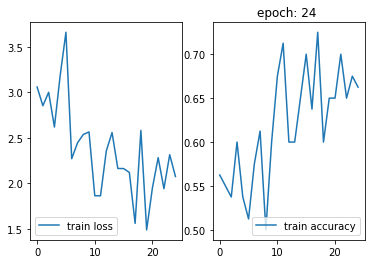

train loss:  2.0766923904418944
train accuracy:  0.6625000238418579
predicted: tensor([0, 0, 1, 1, 0, 1, 1, 1, 1, 0], device='cuda:0')
label: tensor([1, 0, 0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
predicted: tensor([1, 1, 0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
label: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
predicted: tensor([0, 1, 1, 1, 0, 1, 1, 1, 0, 0], device='cuda:0')
label: tensor([0, 0, 1, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
predicted: tensor([1, 0, 0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
label: tensor([1, 0, 0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
predicted: tensor([0, 0, 1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
label: tensor([0, 0, 0, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
predicted: tensor([0, 0, 1, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
label: tensor([1, 0, 0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
predicted: tensor([1, 1, 1, 0, 1, 1, 0, 1, 1, 1], device='cuda:0')
label: tensor([0, 0, 1, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
predicted: tensor([0, 

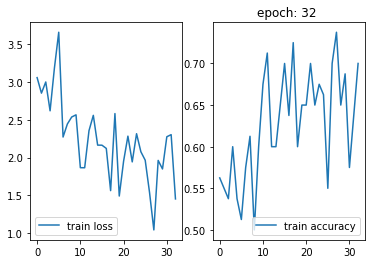

train loss:  1.4510768890380858
train accuracy:  0.699999988079071
predicted: tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 0], device='cuda:0')
label: tensor([0, 0, 0, 1, 0, 1, 1, 0, 1, 1], device='cuda:0')
predicted: tensor([0, 0, 1, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
label: tensor([0, 0, 1, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
predicted: tensor([0, 0, 0, 1, 1, 1, 1, 0, 0, 1], device='cuda:0')
label: tensor([0, 0, 0, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')
predicted: tensor([0, 1, 1, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
label: tensor([0, 0, 0, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
predicted: tensor([0, 1, 0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
label: tensor([0, 0, 0, 1, 0, 1, 1, 0, 1, 0], device='cuda:0')
predicted: tensor([1, 1, 0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
label: tensor([0, 0, 0, 1, 1, 1, 0, 1, 0, 0], device='cuda:0')
predicted: tensor([0, 0, 1, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
label: tensor([0, 0, 0, 0, 1, 1, 1, 1, 1, 0], device='cuda:0')
predicted: tensor([1, 0

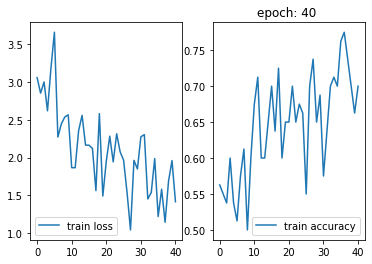

train loss:  1.4132984161376954
train accuracy:  0.699999988079071
predicted: tensor([0, 0, 1, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
label: tensor([0, 0, 0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
predicted: tensor([0, 0, 1, 0, 1, 0, 1, 0, 1, 1], device='cuda:0')
label: tensor([0, 0, 0, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
predicted: tensor([0, 1, 1, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
label: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
predicted: tensor([1, 0, 0, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
label: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
predicted: tensor([0, 1, 0, 1, 1, 1, 1, 0, 1, 0], device='cuda:0')
label: tensor([0, 0, 0, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
predicted: tensor([1, 0, 0, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
label: tensor([0, 0, 0, 0, 1, 1, 1, 0, 1, 0], device='cuda:0')
predicted: tensor([0, 0, 1, 0, 0, 0, 0, 1, 0, 0], device='cuda:0')
label: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
predicted: tensor([0, 1

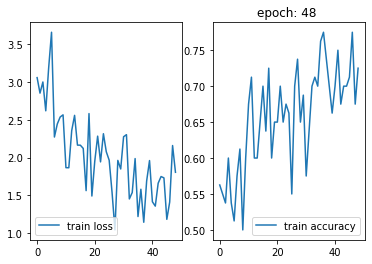

train loss:  1.8042289733886718
train accuracy:  0.7250000238418579
predicted: tensor([1, 1, 0, 1, 0, 1, 1, 0, 1, 0], device='cuda:0')
label: tensor([1, 0, 0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
predicted: tensor([1, 0, 0, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
label: tensor([0, 0, 1, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
predicted: tensor([0, 0, 1, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
label: tensor([0, 0, 0, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
predicted: tensor([0, 0, 1, 0, 1, 1, 0, 0, 1, 1], device='cuda:0')
label: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
predicted: tensor([1, 0, 0, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
label: tensor([0, 0, 0, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')
predicted: tensor([1, 0, 1, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
label: tensor([1, 0, 0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
predicted: tensor([0, 0, 1, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
label: tensor([0, 0, 1, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
predicted: tensor([0, 

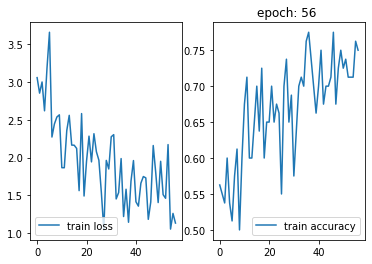

train loss:  1.1307667732238769
train accuracy:  0.75
predicted: tensor([1, 0, 1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
label: tensor([1, 0, 0, 0, 0, 1, 0, 1, 1, 1], device='cuda:0')
predicted: tensor([0, 0, 0, 0, 1, 0, 0, 0, 1, 1], device='cuda:0')
label: tensor([1, 0, 0, 1, 1, 0, 0, 0, 1, 1], device='cuda:0')
predicted: tensor([0, 1, 0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
label: tensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
predicted: tensor([1, 0, 0, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')
label: tensor([0, 0, 0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
predicted: tensor([0, 0, 0, 1, 0, 1, 0, 1, 1, 0], device='cuda:0')
label: tensor([0, 0, 0, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
predicted: tensor([1, 0, 0, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
label: tensor([1, 0, 0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
predicted: tensor([0, 0, 1, 1, 1, 0, 0, 1, 1, 1], device='cuda:0')
label: tensor([0, 0, 0, 1, 1, 0, 0, 0, 1, 1], device='cuda:0')
predicted: tensor([0, 0, 0, 0, 0, 0,

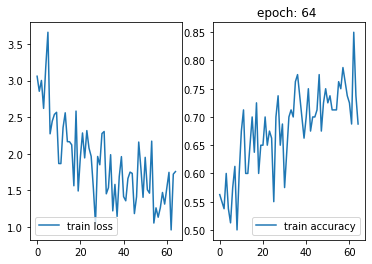

train loss:  1.755324935913086
train accuracy:  0.6875
predicted: tensor([1, 0, 0, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
label: tensor([0, 0, 0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
predicted: tensor([1, 0, 0, 1, 1, 1, 1, 0, 1, 1], device='cuda:0')
label: tensor([0, 0, 0, 1, 1, 0, 0, 0, 1, 1], device='cuda:0')
predicted: tensor([1, 0, 0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
label: tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
predicted: tensor([0, 0, 0, 0, 1, 1, 0, 1, 1, 1], device='cuda:0')
label: tensor([0, 0, 0, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
predicted: tensor([0, 0, 1, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
label: tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
predicted: tensor([1, 0, 0, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
label: tensor([1, 0, 0, 0, 1, 1, 1, 0, 1, 0], device='cuda:0')
predicted: tensor([0, 0, 0, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
label: tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
predicted: tensor([1, 0, 0, 1, 1, 0

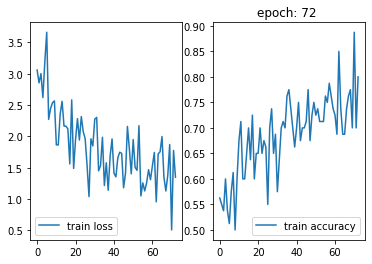

train loss:  1.348915958404541
train accuracy:  0.800000011920929
predicted: tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')
label: tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
predicted: tensor([0, 0, 0, 1, 0, 0, 0, 1, 0, 0], device='cuda:0')
label: tensor([0, 0, 0, 1, 1, 1, 1, 1, 0, 0], device='cuda:0')
predicted: tensor([0, 0, 1, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
label: tensor([0, 0, 0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
predicted: tensor([0, 1, 0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
label: tensor([0, 0, 0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
predicted: tensor([0, 0, 0, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
label: tensor([0, 0, 1, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
predicted: tensor([0, 1, 0, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
label: tensor([0, 0, 1, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
predicted: tensor([1, 0, 0, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
label: tensor([1, 0, 0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
predicted: tensor([1, 0,

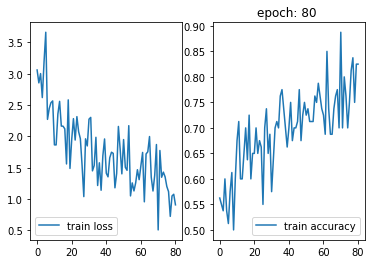

train loss:  0.9089946746826172
train accuracy:  0.824999988079071
predicted: tensor([0, 1, 0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
label: tensor([0, 0, 1, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
predicted: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
label: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
predicted: tensor([0, 0, 0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
label: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
predicted: tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
label: tensor([0, 0, 0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
predicted: tensor([0, 0, 0, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
label: tensor([0, 0, 0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
predicted: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
label: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
predicted: tensor([0, 1, 0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
label: tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
predicted: tensor([1, 0

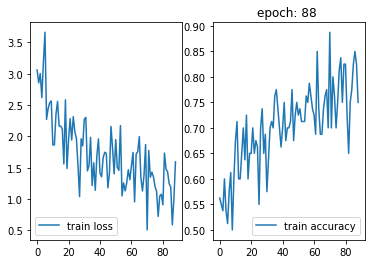

train loss:  1.5942344665527344
train accuracy:  0.75
predicted: tensor([0, 0, 0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
label: tensor([0, 0, 0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
predicted: tensor([0, 0, 1, 0, 1, 1, 0, 1, 1, 1], device='cuda:0')
label: tensor([0, 0, 0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
predicted: tensor([1, 0, 1, 0, 1, 0, 1, 1, 1, 1], device='cuda:0')
label: tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1], device='cuda:0')
predicted: tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
label: tensor([0, 0, 1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
predicted: tensor([1, 0, 0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
label: tensor([0, 0, 0, 1, 1, 1, 1, 0, 1, 0], device='cuda:0')
predicted: tensor([0, 0, 1, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
label: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
predicted: tensor([0, 1, 1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
label: tensor([0, 0, 1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
predicted: tensor([0, 0, 1, 0, 1, 0,

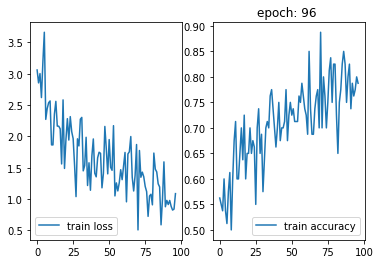

train loss:  1.0879223823547364
train accuracy:  0.7875000238418579
predicted: tensor([0, 1, 0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
label: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
predicted: tensor([0, 0, 1, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
label: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
predicted: tensor([0, 0, 0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
label: tensor([0, 0, 0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
predicted: tensor([0, 0, 1, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
label: tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
predicted: tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
label: tensor([0, 0, 0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
predicted: tensor([1, 0, 0, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
label: tensor([1, 0, 0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
predicted: tensor([1, 0, 0, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
label: tensor([0, 0, 0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
predicted: tensor([0, 

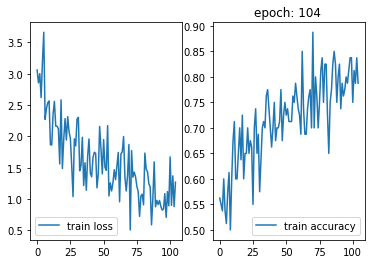

train loss:  1.2706239700317383
train accuracy:  0.7875000238418579
predicted: tensor([0, 0, 0, 1, 1, 1, 1, 0, 1, 0], device='cuda:0')
label: tensor([0, 0, 0, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
predicted: tensor([0, 0, 0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
label: tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
predicted: tensor([0, 0, 0, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
label: tensor([0, 0, 0, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
predicted: tensor([0, 0, 0, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
label: tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
predicted: tensor([1, 0, 0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
label: tensor([0, 0, 0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
predicted: tensor([0, 0, 1, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
label: tensor([1, 0, 0, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')
predicted: tensor([0, 0, 0, 1, 1, 1, 1, 1, 1, 0], device='cuda:0')
label: tensor([0, 0, 0, 1, 1, 1, 1, 0, 1, 0], device='cuda:0')
predicted: tensor([0, 

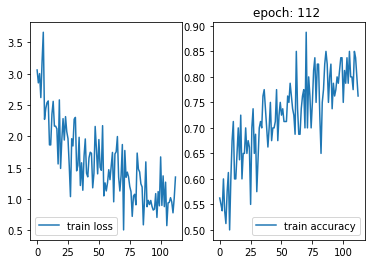

train loss:  1.352456283569336
train accuracy:  0.762499988079071
predicted: tensor([0, 0, 1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
label: tensor([0, 0, 1, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')
predicted: tensor([0, 0, 1, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
label: tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], device='cuda:0')
predicted: tensor([0, 0, 0, 0, 1, 0, 1, 0, 1, 1], device='cuda:0')
label: tensor([0, 0, 0, 0, 1, 1, 1, 0, 1, 1], device='cuda:0')
predicted: tensor([0, 0, 1, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
label: tensor([0, 0, 1, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')
predicted: tensor([0, 0, 0, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
label: tensor([0, 0, 1, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
predicted: tensor([0, 0, 1, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
label: tensor([0, 0, 1, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
predicted: tensor([1, 0, 1, 1, 1, 1, 0, 0, 1, 1], device='cuda:0')
label: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
predicted: tensor([0, 0,

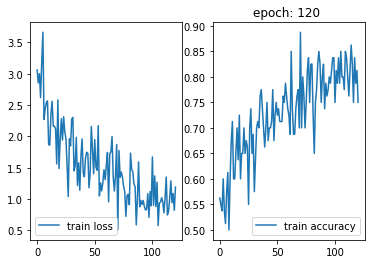

train loss:  1.19218111038208
train accuracy:  0.75
predicted: tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
label: tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
predicted: tensor([0, 1, 0, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
label: tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
predicted: tensor([1, 0, 0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
label: tensor([0, 0, 0, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
predicted: tensor([0, 0, 0, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
label: tensor([1, 0, 0, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
predicted: tensor([0, 0, 0, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
label: tensor([0, 0, 0, 1, 1, 1, 0, 0, 1, 0], device='cuda:0')
predicted: tensor([1, 0, 0, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
label: tensor([1, 0, 0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
predicted: tensor([0, 0, 1, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
label: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')


In [ ]:
# training the model
loss_train = np.array([])
accs_train = np.array([])

for epoch in range(num_epochs):
  i=0
  l_epoch = 0
  correct = 0
  nsamples = 0.0
  for data in train_loader:
    i=i+1
    X,y = data["image"][:,:,:,:,0].to(device),data["label"][:,:,:,:,0].to(device)
    y = (torch.sum(torch.sum(y==4,axis = 3),axis = 2).squeeze()>200).type(torch.LongTensor).to(device) 
    y_hat=net(X)
    correct += (y_hat.argmax(dim=1)==y).sum()
    l=loss(y_hat,y)
    l_epoch+=l
    alg.zero_grad()
    l.backward()
    alg.step()
    nsamples+=len(y)
  print('predicted:', y_hat.argmax(dim=1)[:10])
  print('label:', y[:10])

  loss_train = np.append(loss_train,l_epoch.cpu().detach().numpy()/i)
  accs_train = np.append(accs_train,correct.cpu()/nsamples)


  if epoch%8 == 0:
    plt.subplot(121)
    plt.plot(loss_train,label='train loss')
    plt.legend(loc='lower left')
    plt.subplot(122)
    plt.plot(accs_train,label='train accuracy')
    plt.legend(loc='lower right')
    plt.title('epoch: %d '%(epoch))
    plt.show()
    torch.save(net.state_dict(), os.path.join(
                    path0, "metric_model.pth"))
    print('train loss: ',loss_train[-1])
    print('train accuracy: ',accs_train[-1])

# Inference

In [ ]:
net.load_state_dict(torch.load(
    os.path.join(path0, "metric_model.pth")))
net.eval()

EfficientNetBN(
  (_conv_stem): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (_conv_stem_padding): ConstantPad2d(padding=(0, 1, 0, 1), value=0.0)
  (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  (_blocks): Sequential(
    (0): Sequential(
      (0): MBConvBlock(
        (_expand_conv): Identity()
        (_expand_conv_padding): Identity()
        (_bn0): Identity()
        (_depthwise_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), groups=64, bias=False)
        (_depthwise_conv_padding): ConstantPad2d(padding=(1, 1, 1, 1), value=0.0)
        (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (_se_adaptpool): AdaptiveAvgPool2d(output_size=1)
        (_se_reduce): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
        (_se_reduce_padding): Identity()
        (_se_expand): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (_se_expand_padding): Identity()
       

In [ ]:
data = first(valid_loader)

In [ ]:
X = torch.transpose(data["image"],4,0)
y = torch.transpose(data["label"],4,0)

prob. of enhanced: 99 %


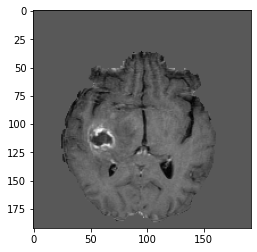

In [ ]:
n=40
with torch.no_grad():
  X0 = X[n,:,:,:,0].unsqueeze(0)
  y_hat = net(X0.to(device))
  print("prob. of enhanced:",int(100*y_hat.softmax(1)[0,1].cpu().numpy()),'%')
  plt.imshow(np.transpose(X0[0,0,:,:],(1,0)),cmap='gray')
  plt.show()